<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)"> Predictive Analysis - Image Processing</h2>


#### Classify handwritten digits using the famous MNIST data

The goal in this task is to take an image of a handwritten single digit, and determine what that digit is.  

The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.  

In [1]:
import os
import sys
import time
import glob
import math
import random
import pickle
import pylab
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from matplotlib import pyplot

from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.decomposition import PCA

import tensorflow as tf

%matplotlib inline
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import Image
from IPython.core.display import HTML

In [2]:
print(tf.__version__)
try:
    physical_devices = tf.config.list_physical_devices('GPU') 
    #tf.config.experimental.set_memory_growth(physical_devices[0], True)
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(physical_devices)
except:
    print("No GPU")

2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-09-10 00:47:21.567174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 00:47:21.604991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 00:47:21.605291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
datapath = "../../../data/"
outputs = "../../../data/"

In [4]:
# read training data from CSV file 

with ZipFile(os.path.join(datapath, 'kaggle_digits_train.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_train.csv') as myfile:
        train_data = pd.read_csv(myfile)
        
with ZipFile(os.path.join(datapath, 'kaggle_digits_test.zip'), 'r') as myzip:
    with myzip.open('kaggle_digits_test.csv') as myfile:
        test_data = pd.read_csv(myfile)

print('data({0[0]},{0[1]})'.format(train_data.shape))
train_data.head()

data(42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Every image is a "stretched" array of pixel values.  
In this case it's 784 pixels => 28 * 28 px  

In [5]:
images = train_data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images numpy array have shape: ({0[0]},{0[1]})'.format(images.shape))

/tmp/ipykernel_208003/2644476569.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)


images numpy array have shape: (42000,784)


In [6]:
images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


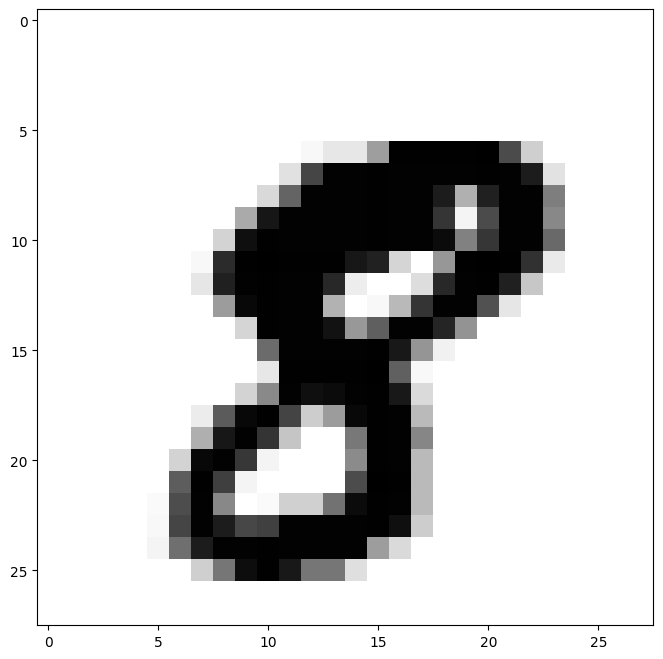

In [8]:
IMAGE_TO_DISPLAY = 10

# (784) => (28,28)
plt.imshow(images[IMAGE_TO_DISPLAY].reshape((28, 28)), cmap=cm.binary)

In [9]:
labels_flat = train_data.iloc[:,0].values

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


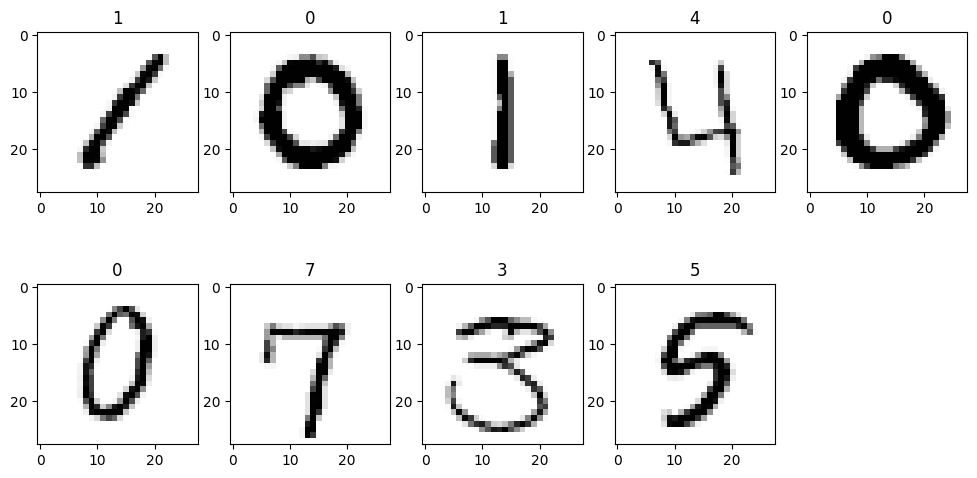

In [10]:
plt.figure(figsize=(12,6))
for i in range(0,9):
    plt.subplot(250 + (i+1))
    img = images[i,:].reshape(28, 28)
    plt.imshow(img, cmap='Greys')
    plt.title(labels_flat[i])

In [11]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [12]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_images = test_data.values.astype(np.float)
test_images.shape

/tmp/ipykernel_208003/452806879.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_data.values.astype(np.float)


(28000, 784)

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, 
                                                                    labels_flat, 
                                                                    test_size=0.4, 
                                                                    random_state=0)
print('train images({0[0]},{0[1]})'.format(X_train.shape))
print('validation images({0[0]},{0[1]})'.format(X_test.shape))
print('train labels({})'.format(y_train.shape))
print('validation labels({})'.format(y_test.shape))

train images(25200,784)
validation images(16800,784)
train labels((25200,))
validation labels((16800,))


In [15]:
from sklearn.ensemble import RandomForestClassifier

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='sqrt', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_train, y_train)

eval_rf = clf_rf.score(X_test, y_test)
print(eval_rf)

/home/renato/Documents/env_default/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.9611904761904762


In [16]:
# Train SVM...
from sklearn import svm
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svm = svm.SVC(kernel='poly',
                  C=1.57,
                  degree=2, 
                  gamma=0.278,
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.001, 
                  cache_size=200, 
                  class_weight=None, 
                  verbose=False, 
                  max_iter=-1, 
                  random_state=0).fit(X_train, y_train)

eval_svm = clf_svm.score(X_test, y_test)
print(eval_svm)

0.9720833333333333


Making Predictions

In [17]:
predict_rf = clf_rf.predict(test_images)
predict_rf[0:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [18]:
predict_svm = clf_svm.predict(test_images)
predict_svm[0:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

### Using Tensor Flow (with a fully connected ANN)

In [19]:
import tensorflow as tf
print(tf.__version__)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

2.9.1


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


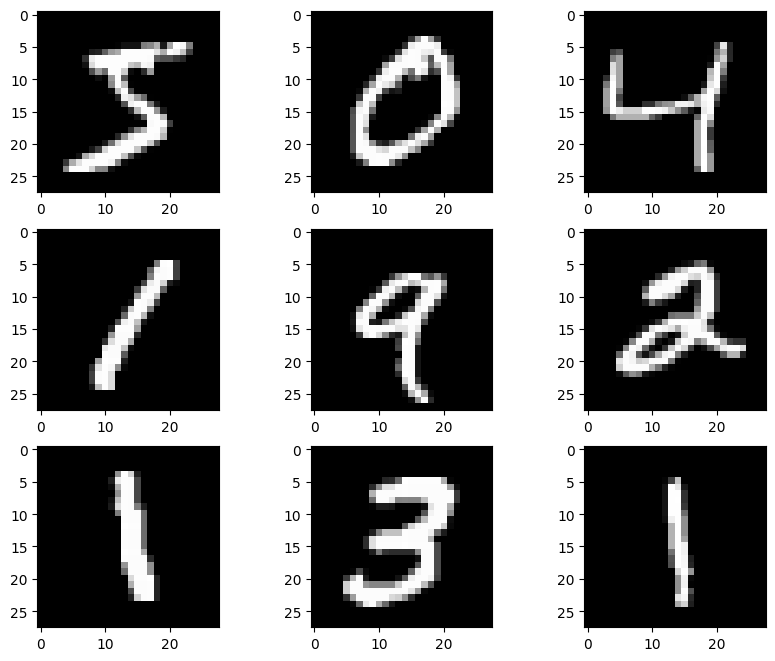

In [20]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [21]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                   ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


2022-09-10 00:49:19.747529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-10 00:49:19.748051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 00:49:19.748527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 00:49:19.748934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
%time model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test,  y_test, verbose=1)

2022-09-10 00:49:20.824348: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-09-10 00:49:20.963847: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2975 - accuracy: 0.9131
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1450 - accuracy: 0.9572
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1070 - accuracy: 0.9675
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0899 - accuracy: 0.9726
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0748 - accuracy: 0.9764
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0658 - accuracy: 0.9784
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0575 - accuracy: 0.9815
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0534 - accuracy: 0.9829
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0491 - accuracy: 0.9847
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.044

2022-09-10 00:49:47.942231: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.
2022-09-10 00:49:47.973279: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


313/313 [==============================] - 1s 1ms/step - loss: 0.0719 - accuracy: 0.9785


[0.07186712324619293, 0.9785000085830688]

### Using Tensor Flow (with a CNN)

### a) simple model

In [23]:
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# baseline cnn model for mnist

(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# one hot encode target values
trainY = tf.keras.utils.to_categorical(trainY)
testY = tf.keras.utils.to_categorical(testY)
# scale pixels
trainX, testX = prep_pixels(trainX, testX)



model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32, 
                                                           kernel_size=(3, 3), 
                                                           activation='relu', 
                                                           kernel_initializer='he_uniform', 
                                                           input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
                                    tf.keras.layers.Dense(10, activation='softmax'),
                                   ])

model.compile(optimizer='adam', #SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               540900    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

In [24]:
%time model.fit(trainX, trainY, epochs=10)
model.evaluate(testX, testY, verbose=1)

Epoch 1/10


2022-09-10 00:49:49.349304: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-09-10 00:49:50.168368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


1875/1875 [==============================] - 6s 2ms/step - loss: 0.1433 - accuracy: 0.9570
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0474 - accuracy: 0.9855
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0293 - accuracy: 0.9908
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0186 - accuracy: 0.9944
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0130 - accuracy: 0.9958
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0093 - accuracy: 0.9969
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0075 - accuracy: 0.9976
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0061 - accuracy: 0.9978
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0052 - accuracy: 0.9982
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0034 - accurac

[0.06583531200885773, 0.9868999719619751]

### b) slightly bigger model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, 
                                 kernel_size=(3, 3),
                                 activation='relu',
                                 kernel_initializer='he_uniform',
                                 input_shape=(28, 28, 1)
                                ))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY,batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1743 - accuracy: 0.9476 - val_loss: 0.0420 - val_accuracy: 0.9863
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0741 - accuracy: 0.9778 - val_loss: 0.0375 - val_accuracy: 0.9887
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0580 - accuracy: 0.9822 - val_loss: 0.0352 - val_accuracy: 0.9899
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0454 - accuracy: 0.9859 - val_loss: 0.0299 - val_accuracy: 0.9908
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0372 - accuracy: 0.9887 - val_loss: 0.0360 - val_accuracy: 0.9899
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0321 - accuracy: 0.9897 - val_loss: 0.0364 - val_accuracy: 0.9913
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.0335 - val_accuracy:

[0.03354470059275627, 0.9919999837875366]

In [28]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0335 - accuracy: 0.9920
Test loss: 0.03354470059275627
Test accuracy: 0.9919999837875366


In [29]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.174349,0.947583,0.042027,0.9863
1,0.074081,0.977833,0.037466,0.9887
2,0.057976,0.982150,0.035213,0.9899
3,0.045386,0.985917,0.029852,0.9908
4,0.037159,0.988717,0.035968,0.9899


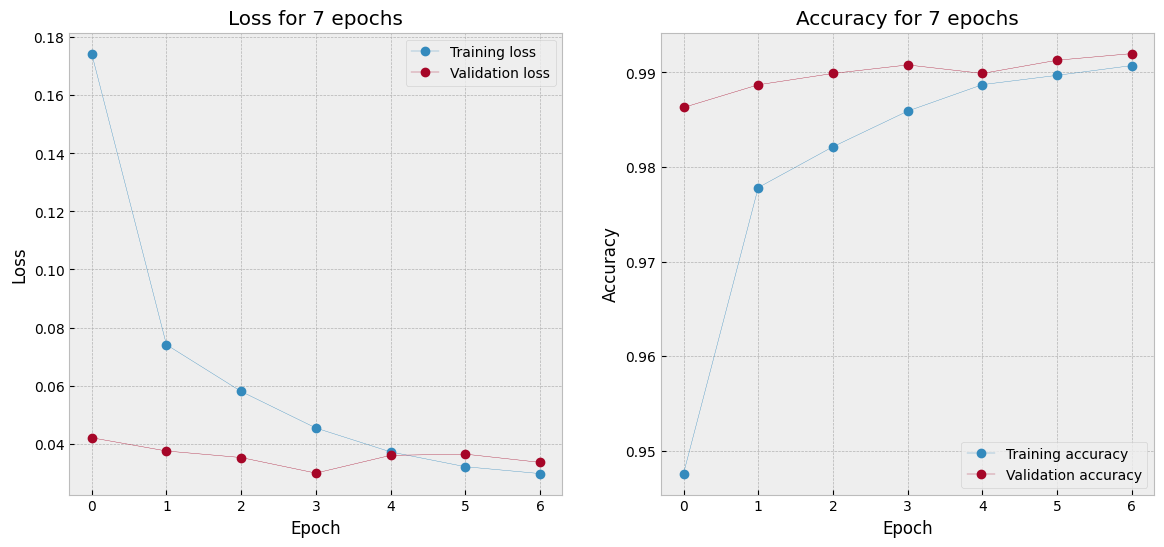

In [30]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### c) [Using the LENET architecture](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/  )

![](../../../images/lenet_architecture-768x226.png)

The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition. As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.  

The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs — it can even run on the CPU (if your system does not have a suitable GPU), making it a great “first CNN”.  

However, if you do have GPU support and can access your GPU via Keras, you will enjoy extremely fast training times (in the order of 3-10 seconds per epoch, depending on your GPU).  

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(filters=20, kernel_size = (5, 5), padding = "same", input_shape = (28, 28, 1)))
model.add(tf.keras.layers.Activation(activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides =  (2, 2)))
model.add(tf.keras.layers.Convolution2D(filters=50, kernel_size = (5, 5), padding = "same"))
model.add(tf.keras.layers.Activation(activation= "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500))
model.add(tf.keras.layers.Activation(activation = "relu"))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation("softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 20)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                  

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])

model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1049 - accuracy: 0.9675 - val_loss: 0.0416 - val_accuracy: 0.9876
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0357 - accuracy: 0.9885 - val_loss: 0.0377 - val_accuracy: 0.9891
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0303 - val_accuracy: 0.9904
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.0361 - val_accuracy: 0.9908
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.0340 - val_accuracy: 0.9896
CPU times: user 41.1 s, sys: 3.35 s, total: 44.5 s
Wall time: 29.8 s
313/313 [==============================] - 1s 2ms/step - loss: 0.03

[0.03399655222892761, 0.9896000027656555]

In [33]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0340 - accuracy: 0.9896
Test loss: 0.03399655222892761
Test accuracy: 0.9896000027656555


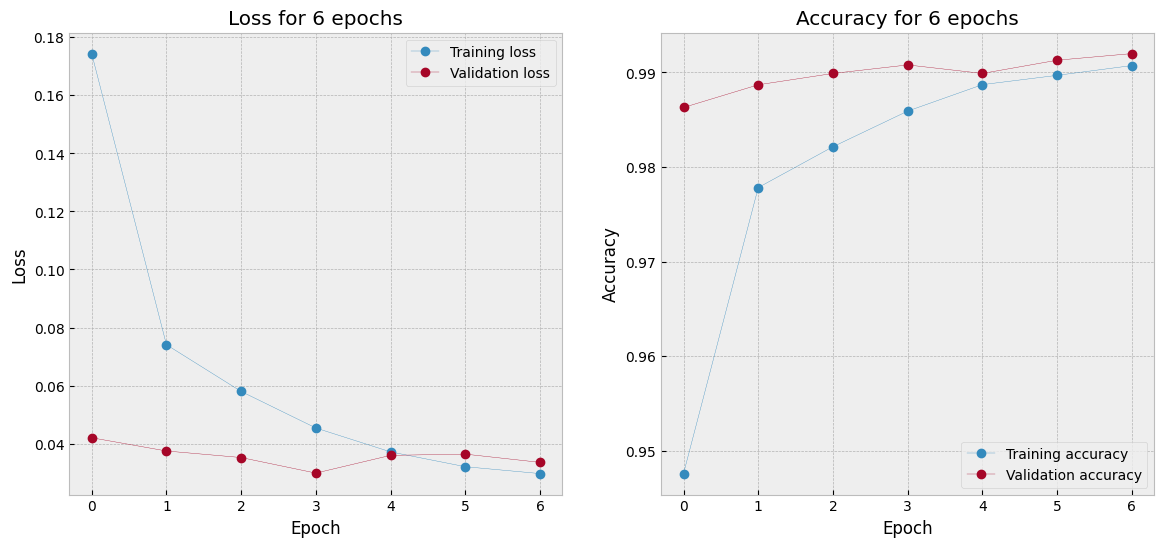

In [34]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### d) Testing a more complex model

![](https://sihamtabik.github.io/LeNet-like-CNN.jpg)

In [35]:
nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.ZeroPadding2D((1,1), input_shape=(28, 28, 1),))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv),  activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_1, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_2, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.ZeroPadding2D((1, 1)))
model.add(tf.keras.layers.Conv2D(nb_filters_3, (nb_conv, nb_conv), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(strides=(2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.summary()

model.compile(optimizer='adam', #tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 30, 30, 1)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 30, 30, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

%time history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=1, \
                          validation_data=(testX, testY), callbacks=[early_stopping])
model.evaluate(testX, testY, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1486 - accuracy: 0.9528 - val_loss: 0.0399 - val_accuracy: 0.9885
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0514 - accuracy: 0.9847 - val_loss: 0.0724 - val_accuracy: 0.9762
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0430 - accuracy: 0.9878 - val_loss: 0.0426 - val_accuracy: 0.9868
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.0243 - val_accuracy: 0.9923
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0288 - accuracy: 0.9915 - val_loss: 0.0284 - val_accuracy: 0.9927
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0257 - accuracy: 0.9927 - val_loss: 0.0437 - val_accuracy: 0.9896
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0235 - accuracy: 0.9932 - val_loss: 0.0241 - val_accuracy

[0.03731057047843933, 0.9909999966621399]

In [37]:
score = model.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0373 - accuracy: 0.9910
Test loss: 0.03731057047843933
Test accuracy: 0.9909999966621399


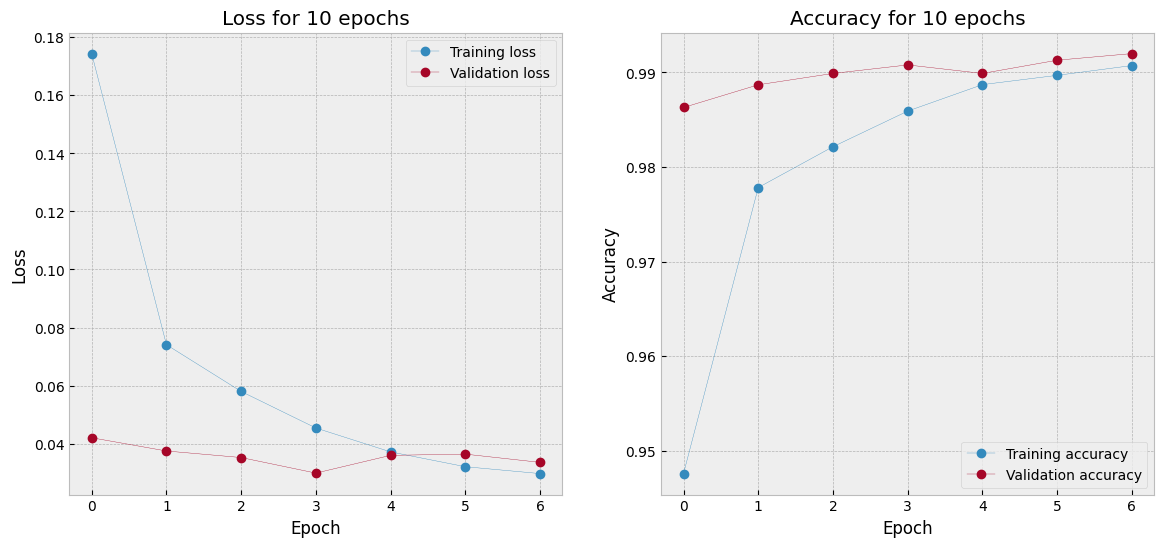

In [38]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.accuracy, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_accuracy, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Pre-trained models  

How can I use pre-trained models in Keras?  
Code and pre-trained weights are available for the following image classification models:  
+ Xception  
+ VGG16  
+ VGG19  
+ ResNet50  
+ Inception v3  

They can be imported from the module [keras.applications](https://keras.io/applications/):

In [39]:
#from keras.applications.xception import Xception
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet50 import ResNet50
#from keras.applications.inception_v3 import InceptionV3

#model = VGG16(weights='imagenet', include_top=True)

[Transfer Learning and Fine-Tuning](https://keras.io/guides/transfer_learning/)
[Visualizing the classification task:](http://scs.ryerson.ca/~aharley/vis/fc/)